In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import numpy as np
import pandas as pd
import torch
import pyvista as pv

sys.path.append('../..')
import project
import project.preprocessing
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
pprint(ds, max_depth=2)

ShapeNetDataset()
├── root:       PosixPath('../../data/ShapeNetSem')
├── metadata:   DataFrame(shape=(12288, 16))
|   ├── 'fullId':          Series(len=12288, dtype=object)
|   ├── 'category':        Series(len=12288, dtype=object)
|   ├── 'wnsynset':        Series(len=12288, dtype=object)
|   ├── 'wnlemmas':        Series(len=12288, dtype=object)
|   ├── 'up':              Series(len=12288, dtype=object)
|   ├── 'front':           Series(len=12288, dtype=object)
|   ├── 'unit':            Series(len=12288, dtype=float64)
|   ├── 'aligned.dims':    Series(len=12288, dtype=object)
|   ├── 'isContainerLike': Series(len=12288, dtype=float64)
|   ├── 'surfaceVolume':   Series(len=12288, dtype=float64)
|   └── <6 more items>
├── categories: DataFrame(shape=(283, 5))
|   ├── 'category':     Series(len=283, dtype=object)
|   ├── 'matchLevel':   Series(len=283, dtype=int64)
|   ├── 'synset':       Series(len=283, dtype=object)
|   ├── 'synset words': Series(len=283, dtype=object)
|   └── 'syn

In [6]:
%autoreload
# wss.101354f9d8dede686f7b08d9de913afe - speaker
# wss.1e5abf0465d97d826118a17db9de8c0  - bottle
# wss.fabf4f7a56f75781c9c120e7b18610ad - donut
# wss.38c6a54843046bef5bbc469684caa508 - disconnected
# wss.ce4945cde785aecb478fa0ab37c461c6 - piano
# wss.e91c2df09de0d4b1ed4d676215f46734 - bed (error- 1 cell labeled background)

subj = 'wss.1e5abf0465d97d826118a17db9de8c0'
ex = next(ds.examples(subjects=[subj], variant='2025-11-02'))
pprint(ex, max_depth=3)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.1e5abf0465d97d826118a17db9de8c0'
├── variant:  '2025-11-02'
├── paths:    dict(len=14)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/1e5abf0465d97d826118a17db9de8c0.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/1e5abf0465d97d826118a17db9de8c0.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/volume.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/material.nii.gz')
| 

# Visualize object mesh

In [99]:
# visualization config
size = 1200
lw = 2.0

Loading ../../data/ShapeNetSem/models-OBJ/models/1e5abf0465d97d826118a17db9de8c0.obj


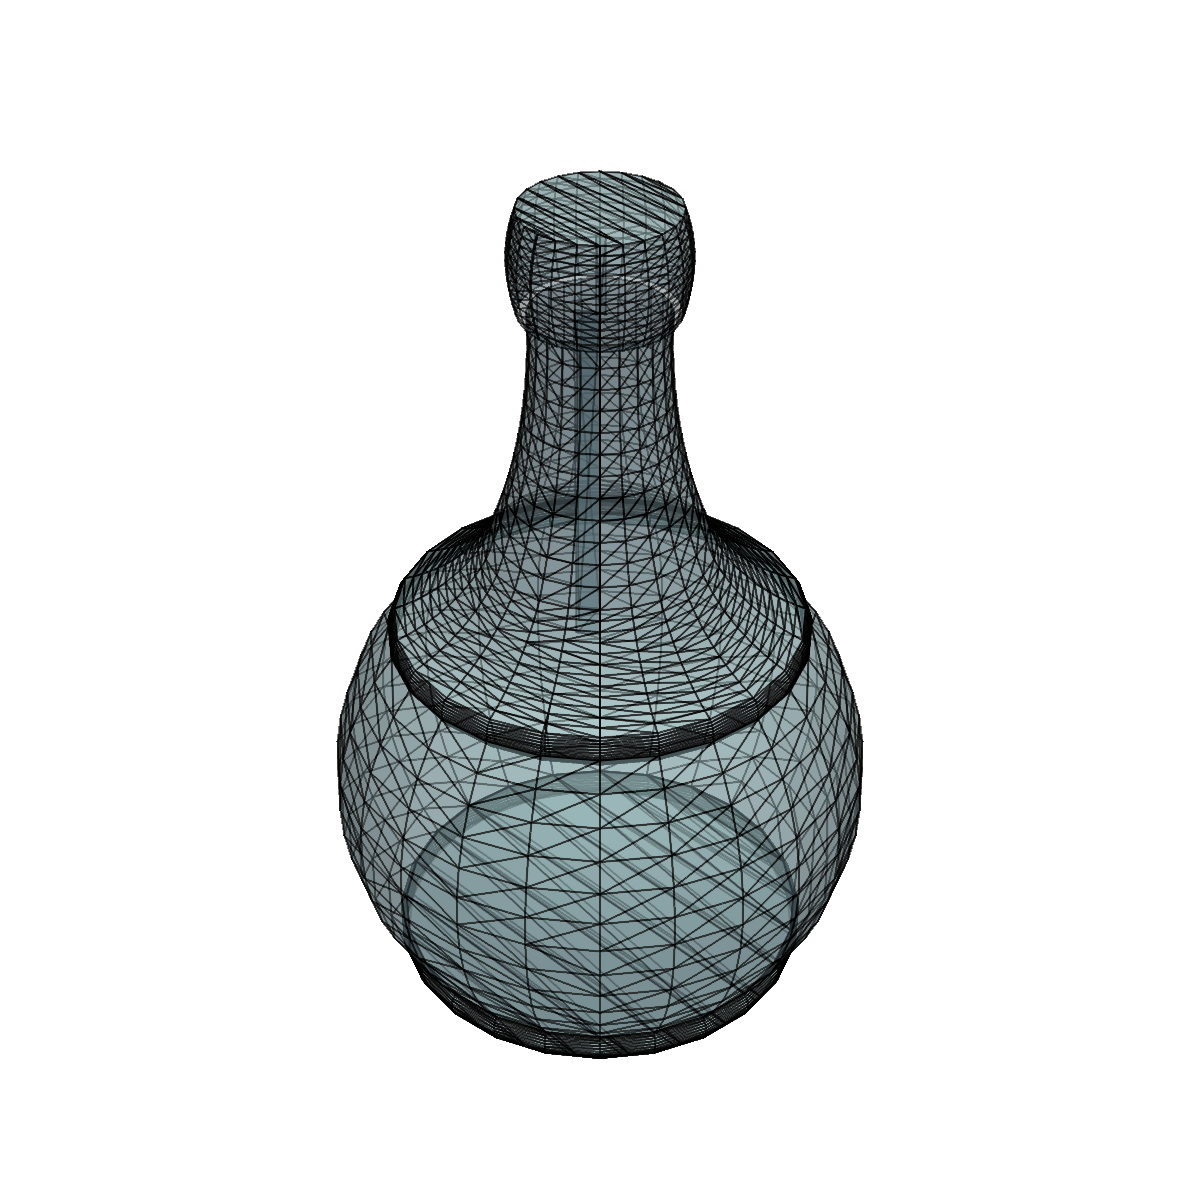

In [100]:
%autoreload
import project.visual.pyvista as pv

src_mesh = project.core.fileio.load_meshio(ex.paths['source_mesh'])

p = pv.pv.Plotter(window_size=[size,size])
pv.plot_mesh(src_mesh, color='lightblue', show_edges=True, opacity=0.5, line_width=lw, plotter=p)
pv.plot_mesh(src_mesh, style='wireframe', color='black', opacity=0.5, line_width=lw, plotter=p)
cam = p.camera
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/models-OBJ/models/1e5abf0465d97d826118a17db9de8c0.obj


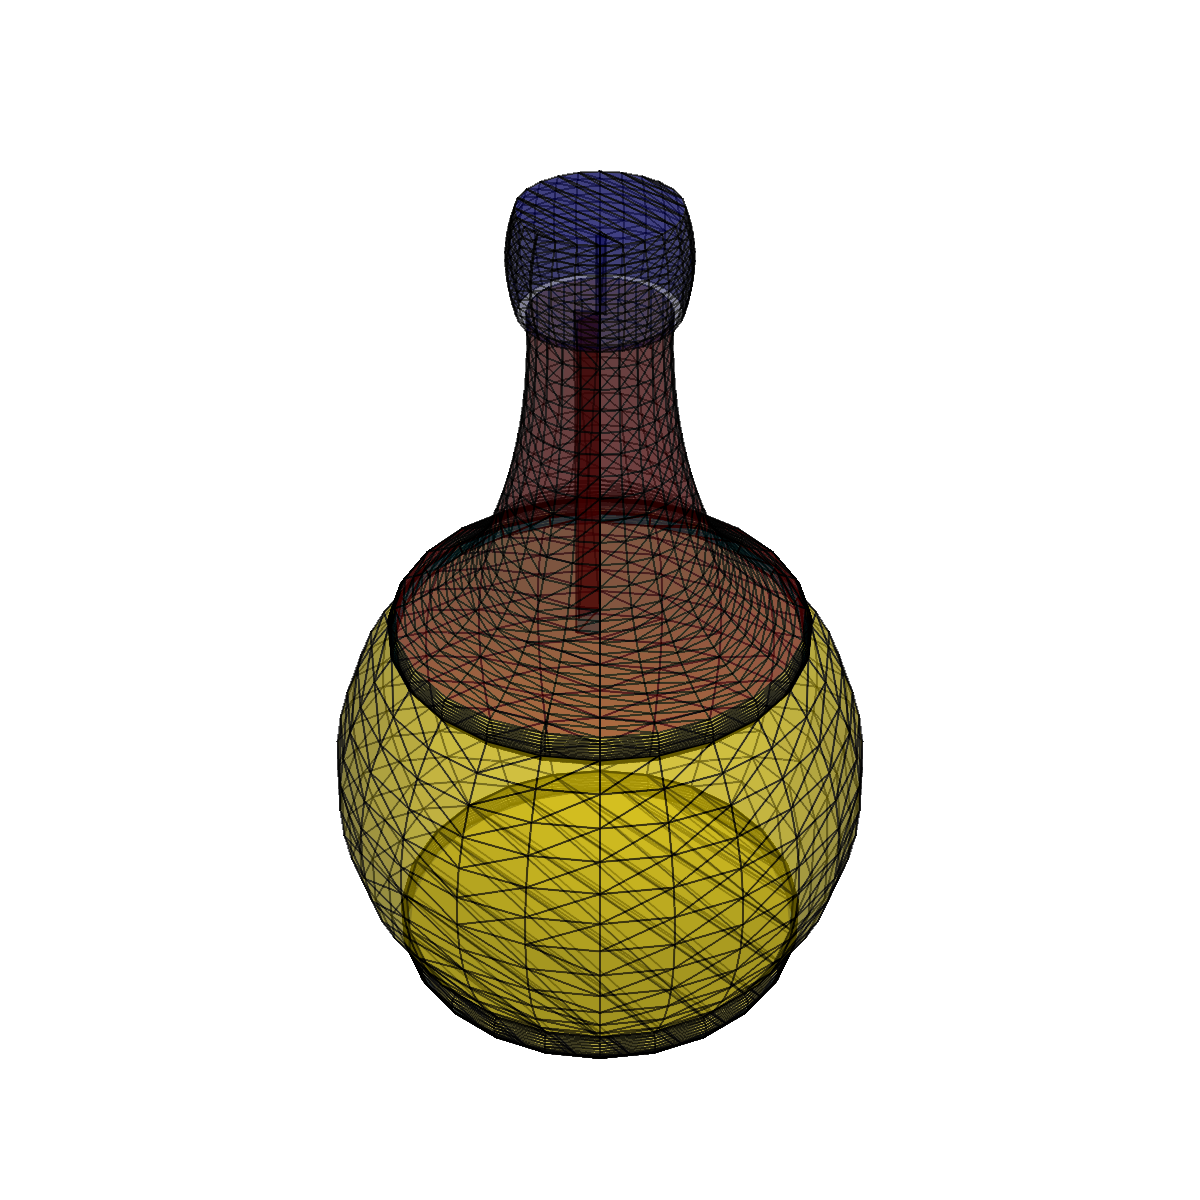

In [103]:
import project.preprocessing.surface_meshing

scene = project.core.fileio.load_trimesh(ex.paths['source_mesh'])
label_mesh, mesh_labels = project.preprocessing.surface_meshing.extract_face_labels(scene)
label_mesh = pv.pv.wrap(label_mesh)
label_mesh.cell_data['label'] = mesh_labels

p = pv.pv.Plotter(window_size=[size,size])
pv.plot_mesh(label_mesh, scalar='label', cmap='jet', show_edges=True, opacity=0.5, line_width=lw, plotter=p, show_scalar_bar=False)
pv.plot_mesh(src_mesh, style='wireframe', color='black', opacity=0.5, line_width=lw, plotter=p)
p.camera = cam
p.show(jupyter_backend='static')

# Preprocess binary mask

In [10]:
%autoreload
project.preprocessing.api.preprocess_binary_mask(
    mask_path=ex.paths['source_mask'],
    mesh_path=ex.paths['source_mesh'],
    output_path=ex.paths['binary_mask']
)

Loading ../../data/ShapeNetSem/models-binvox-solid/fabf4f7a56f75781c9c120e7b18610ad.binvox
Loading ../../data/ShapeNetSem/models-OBJ/models/fabf4f7a56f75781c9c120e7b18610ad.obj
Inferring affine from mesh bounding box
Binvox shape:     [128 128 128]
Binvox translate: [ 3131.66 -2144.15 -3079.76]
Binvox scale:     9.20993e-05
Points bbox min:    [-3131.66  2144.15  3079.76]
Points bbox extent: [10857.83 10857.85  3749.  ]
(-1, -1)
[[ 8.48269205e+01  0.00000000e+00  0.00000000e+00 -3.08924654e+03]
 [ 0.00000000e+00  8.48269205e+01  0.00000000e+00  2.18656346e+03]
 [ 0.00000000e+00  0.00000000e+00  8.48269205e+01  3.12217346e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Cleaning up binary mask
Filtering foreground
Input 1-connected components: 2
  Voxel counts:   [395096      1] 395097
Output 1-connected components: 1
  Voxels dropped: 1 (0.0003%)
Filtering background
Input 1-connected components: 5
  Voxel counts:   [1702052       1       1       1       1] 1702

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/binary.nii.gz


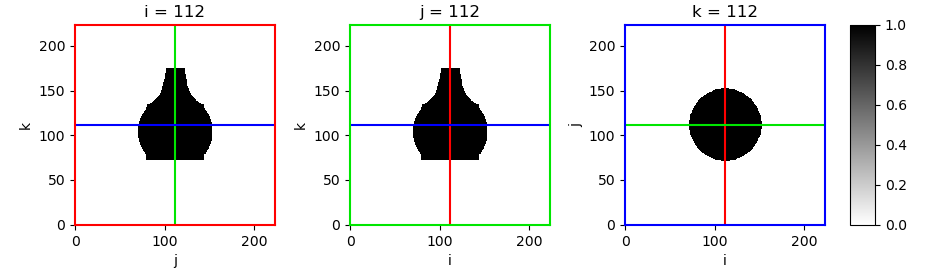

In [104]:
bin_nifti = project.core.fileio.load_nibabel(ex.paths['binary_mask'])
bin_mask, bin_affine = bin_nifti.get_fdata(), bin_nifti.affine

_ = project.visual.matplotlib.show_image_slices(bin_mask, cmap='binary', clim=(0,1))

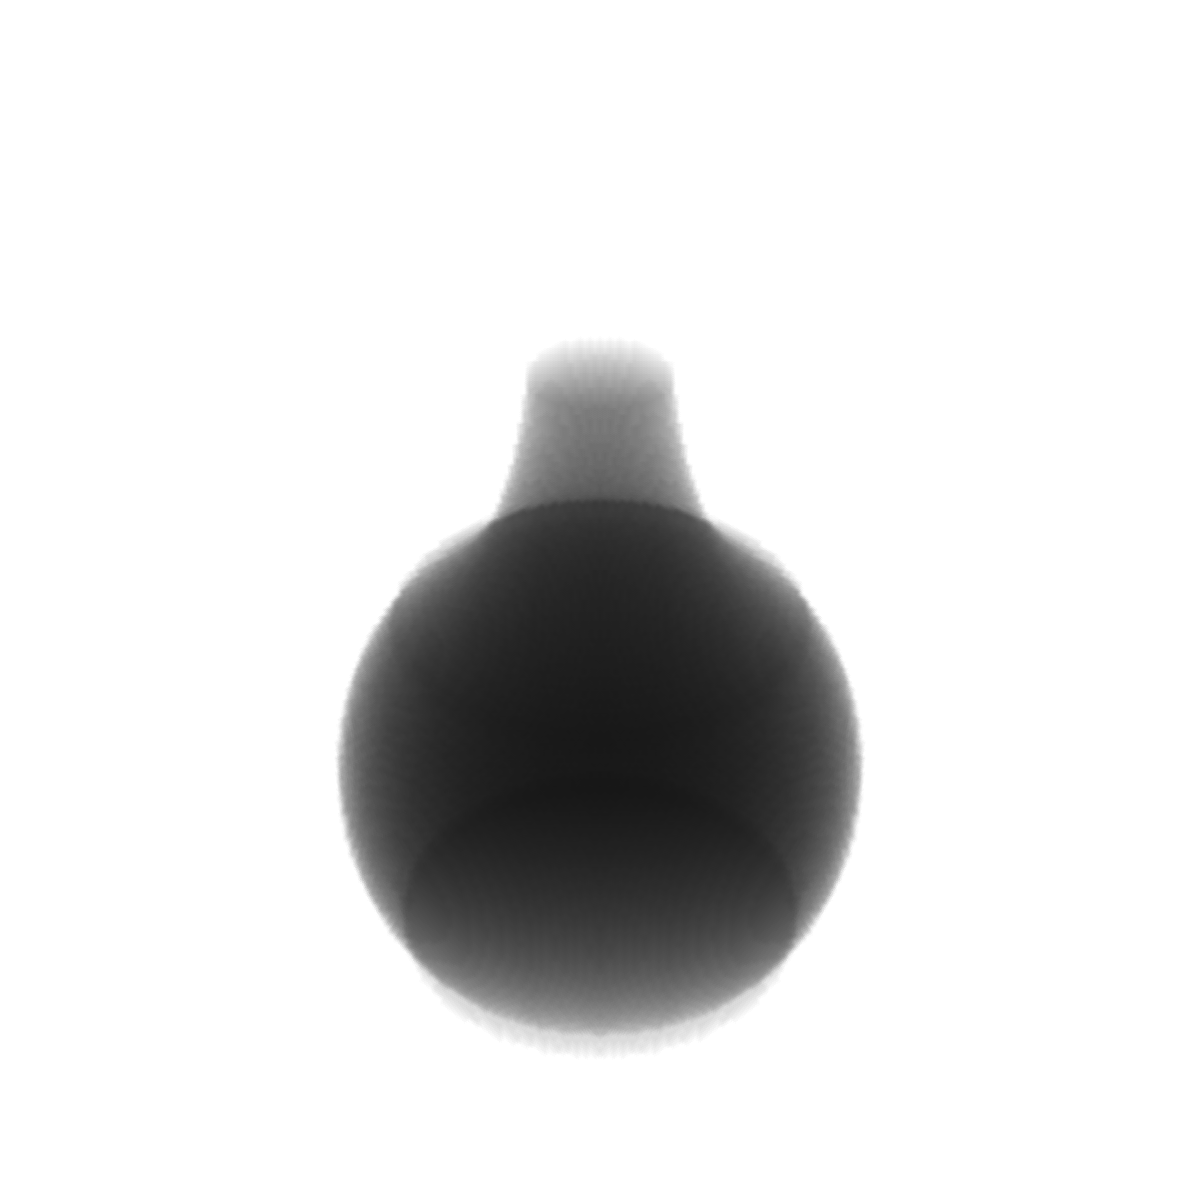

In [113]:
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_volume(bin_mask, bin_affine, cmap=['black'], clim=(0, 1), opacity=[0,0.05], plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(src_mesh, color='lightblue', opacity=0.1, plotter=p, show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

# Preprocess surface mesh

In [13]:
project.preprocessing.api.preprocess_surface_mesh(
    input_path=ex.paths['source_mesh'],
    output_path=ex.paths['surface_mesh']
)

Loading ../../data/ShapeNetSem/models-OBJ/models/fabf4f7a56f75781c9c120e7b18610ad.obj
Repairing surface mesh
Initial mesh state:
dict(len=7)
├── 'vertices':     7056
├── 'faces':        2352
├── 'edges':        dict(len=3)
|   ├── 'boundary':    7056
|   ├── 'interior':    0
|   └── 'nonmanifold': 0
├── 'euler_number': 2352
├── 'watertight':   False
├── 'components':   2352
└── 'angles':       dict(len=3)
    ├── 'p05': 19.55253638482845
    ├── 'p50': 59.50566301467058
    └── 'p95': 96.92610535736159

After trimesh repair:
dict(len=7)
├── 'vertices':     576
├── 'faces':        1200
├── 'edges':        dict(len=3)
|   ├── 'boundary':    0
|   ├── 'interior':    1728
|   └── 'nonmanifold': 48
├── 'euler_number': 0
├── 'watertight':   False
├── 'components':   3
└── 'angles':       dict(len=3)
    ├── 'p05': 19.55242873289503
    ├── 'p50': 59.505510699201835
    └── 'p95': 96.9264228183694
Removed 1 small components
Patching holes...
Patched 2 holes
Fixing degeneracies and intersectio

WARNING- Some cuts were necessary to cope with non manifold configuration.


Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/surface.xdmf


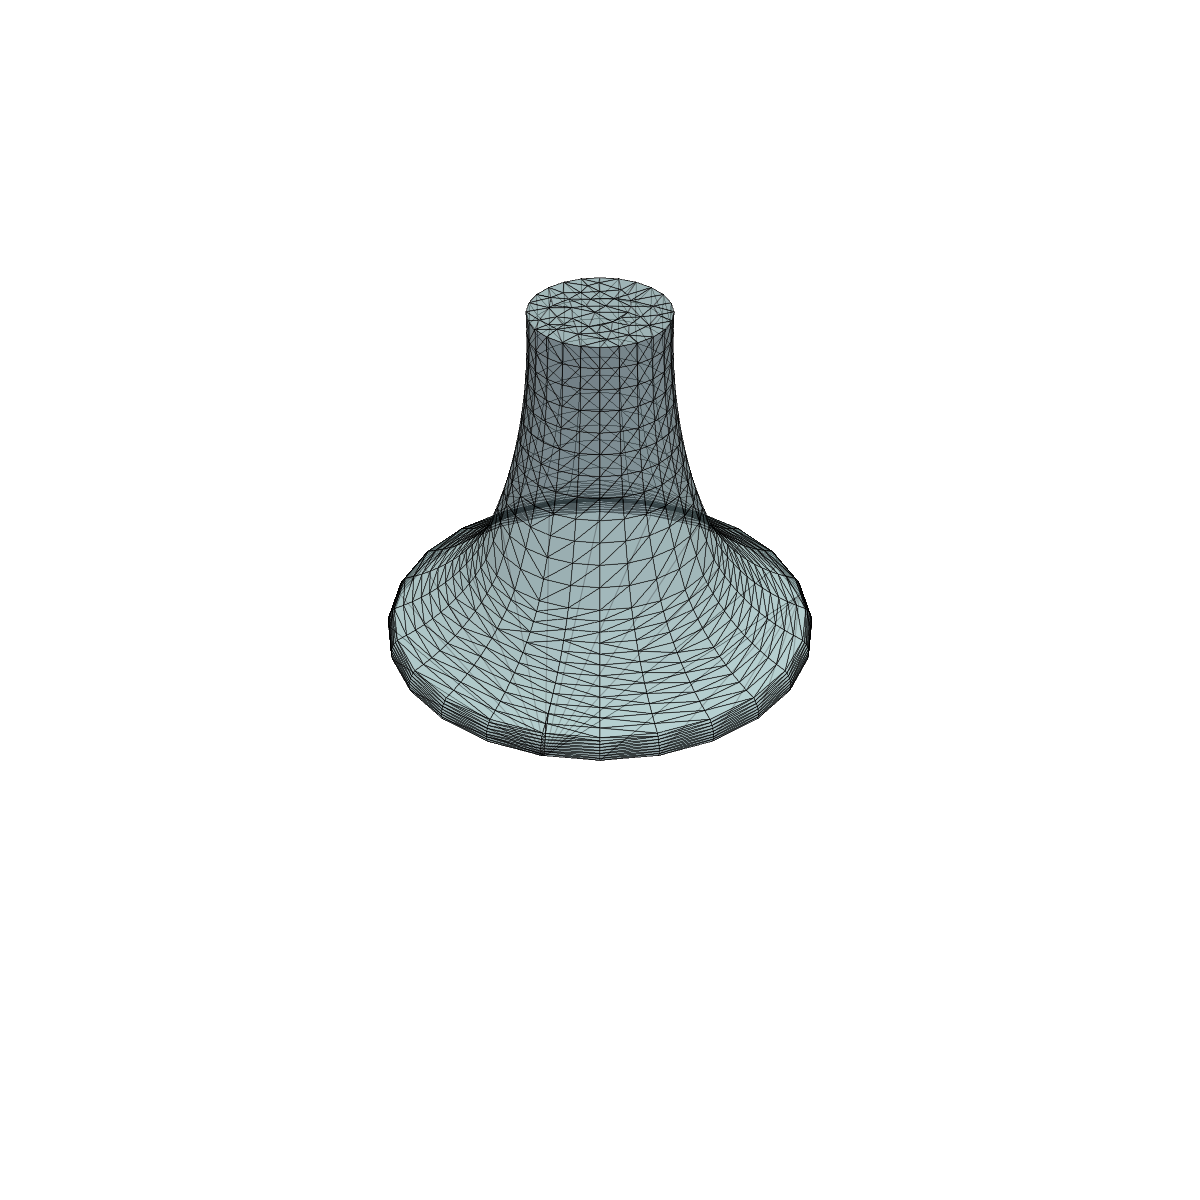

In [114]:
tri_mesh = project.core.fileio.load_meshio(ex.paths['surface_mesh'])

size = 1200
p = pv.pv.Plotter(window_size=[size,size])
pv.plot_mesh(tri_mesh, color='lightblue', show_edges=True, opacity=0.5, plotter=p)
pv.plot_mesh(tri_mesh, style='wireframe', color='black', opacity=0.5, plotter=p)
p.camera = cam
p.show(jupyter_backend='static')

# Assign region labels

In [15]:
project.preprocessing.api.create_mesh_region_mask(
    mask_path=ex.paths['binary_mask'],
    mesh_path=ex.paths['source_mesh'],
    output_path=ex.paths['region_mask']
)

Loading ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/masks/binary.nii.gz
Loading ../../data/ShapeNetSem/models-OBJ/models/fabf4f7a56f75781c9c120e7b18610ad.obj
Extracting labels from mesh
Assigning labels to voxels
100%|████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]
Cleaning up region mask
Filtering region 1
Input 1-connected components: 1
  Voxel counts:   [362776] 362776
Output 1-connected components: 1
  Voxels dropped: 0 (0.0000%)
Filtering region 2
Input 1-connected components: 1
  Voxel counts:   [32324] 32324
Output 1-connected components: 1
  Voxels dropped: 0 (0.0000%)
Saving ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/masks/regions.nii.gz
Done


Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/regions.nii.gz


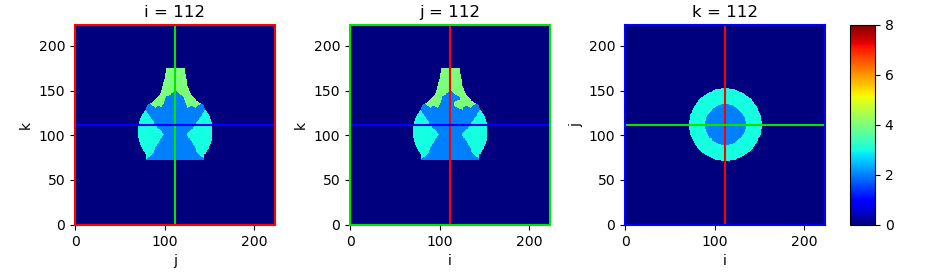

In [115]:
%autoreload
region_nifti = project.core.fileio.load_nibabel(ex.paths['region_mask'])
region_mask = region_nifti.get_fdata().astype(int)

fig = project.visual.matplotlib.show_image_slices(region_mask, cmap='jet', clim=(0, 8))

In [17]:
1 / np.histogram(region_mask, range=(0, 8), bins=9, density=True)[0]

/var/tmp/ipykernel_32443/1638174408.py:1: RuntimeWarning: divide by zero encountered in divide
  1 / np.histogram(region_mask, range=(0, 8), bins=9, density=True)[0]


array([  0.92127449,  27.53930555, 309.07681943,          inf,
                inf,          inf,          inf,          inf,
                inf])

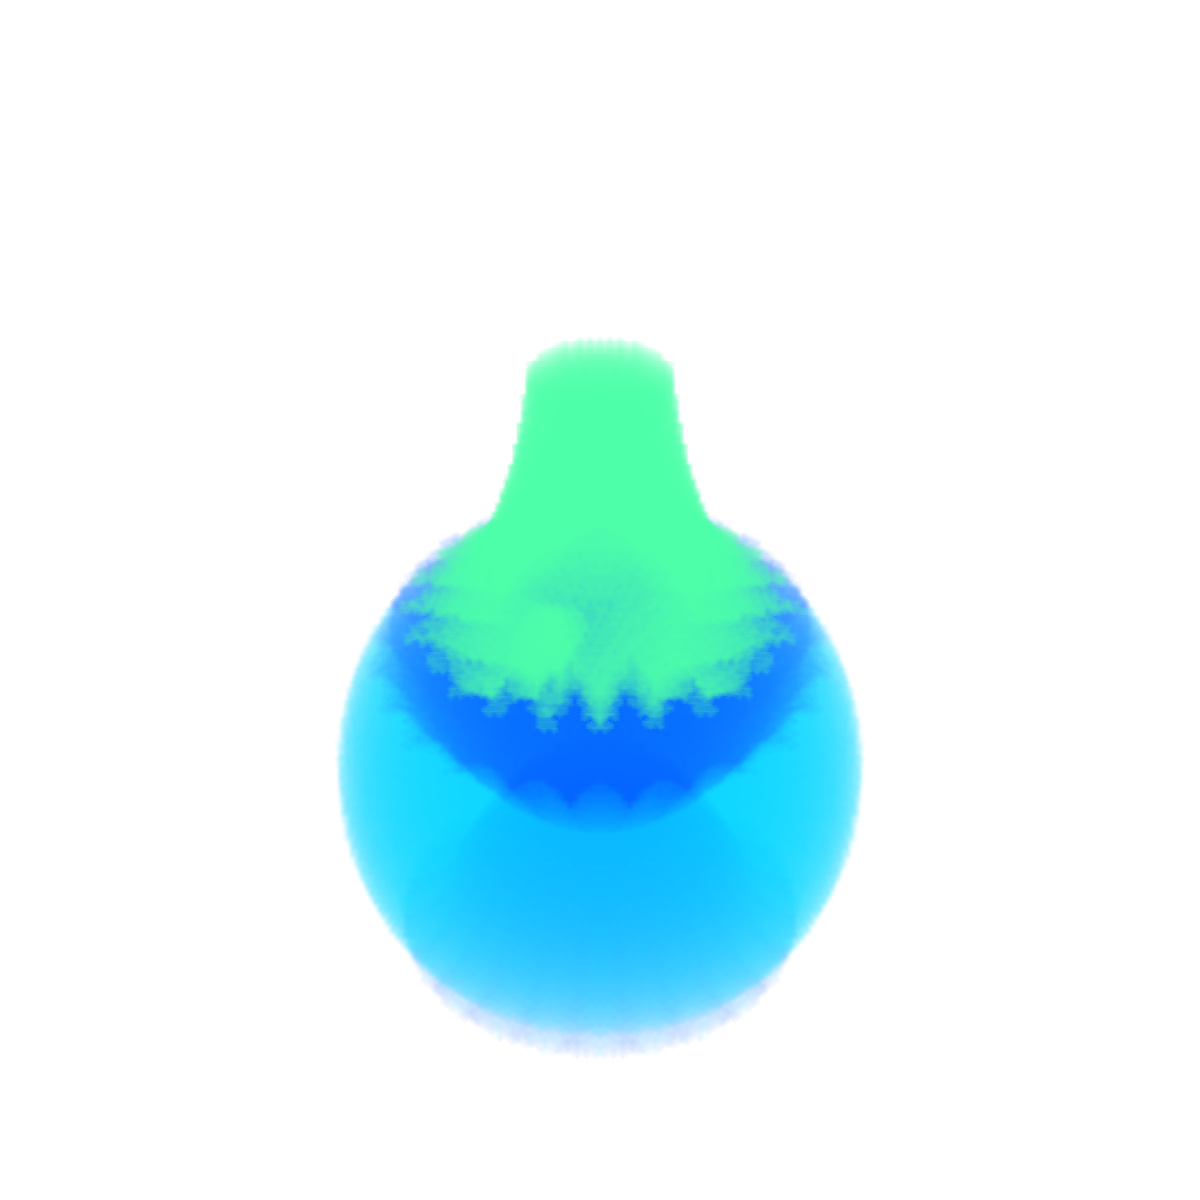

In [123]:
def _opacity(a, n, alpha=20000, relative=False):
    clim = (0, n - 1)
    freqs, edges = np.histogram(a, range=clim, bins=n, density=relative)
    sel = (freqs > 0) & (edges[:-1] > 0)
    opacity = np.zeros_like(freqs, dtype=float)
    opacity[sel] = np.minimum(alpha / freqs[sel], 1.0)
    return clim, opacity

clim, opacity = _opacity(region_mask, n=10, alpha=10000)
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_volume(region_mask, bin_affine, cmap='jet', clim=clim, opacity=opacity, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_volume(region_mask, bin_affine, cmap='jet', clim=(0, 8), opacity=opacity, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(src_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

# Generate volume mesh from region mask

In [20]:
project.preprocessing.api.create_volume_mesh_from_mask(
    mask_path=ex.paths['region_mask'],
    output_path=ex.paths['volume_mesh'],
    use_affine_spacing=False,
    pygalmesh_kws=dict(
        max_facet_distance=0.75,
        max_cell_circumradius=5.0,
        odt=True, lloyd=True,
    )
)

Loading ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/masks/regions.nii.gz
Generating volume mesh from mask
Removed 0 unreferenced point(s)
1 14462 [    3 14346   113]
2 3223 [   2   82 3139]
[-1  1  2]
Mesh has 1 connected component(s)
<meshio mesh object>
  Number of points: 3845
  Number of cells:
    triangle: 10336
    tetra: 17685
  Point data: medit:ref
  Cell data: label
Saving ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/meshes/volume.xdmf
Done


Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/volume.xdmf


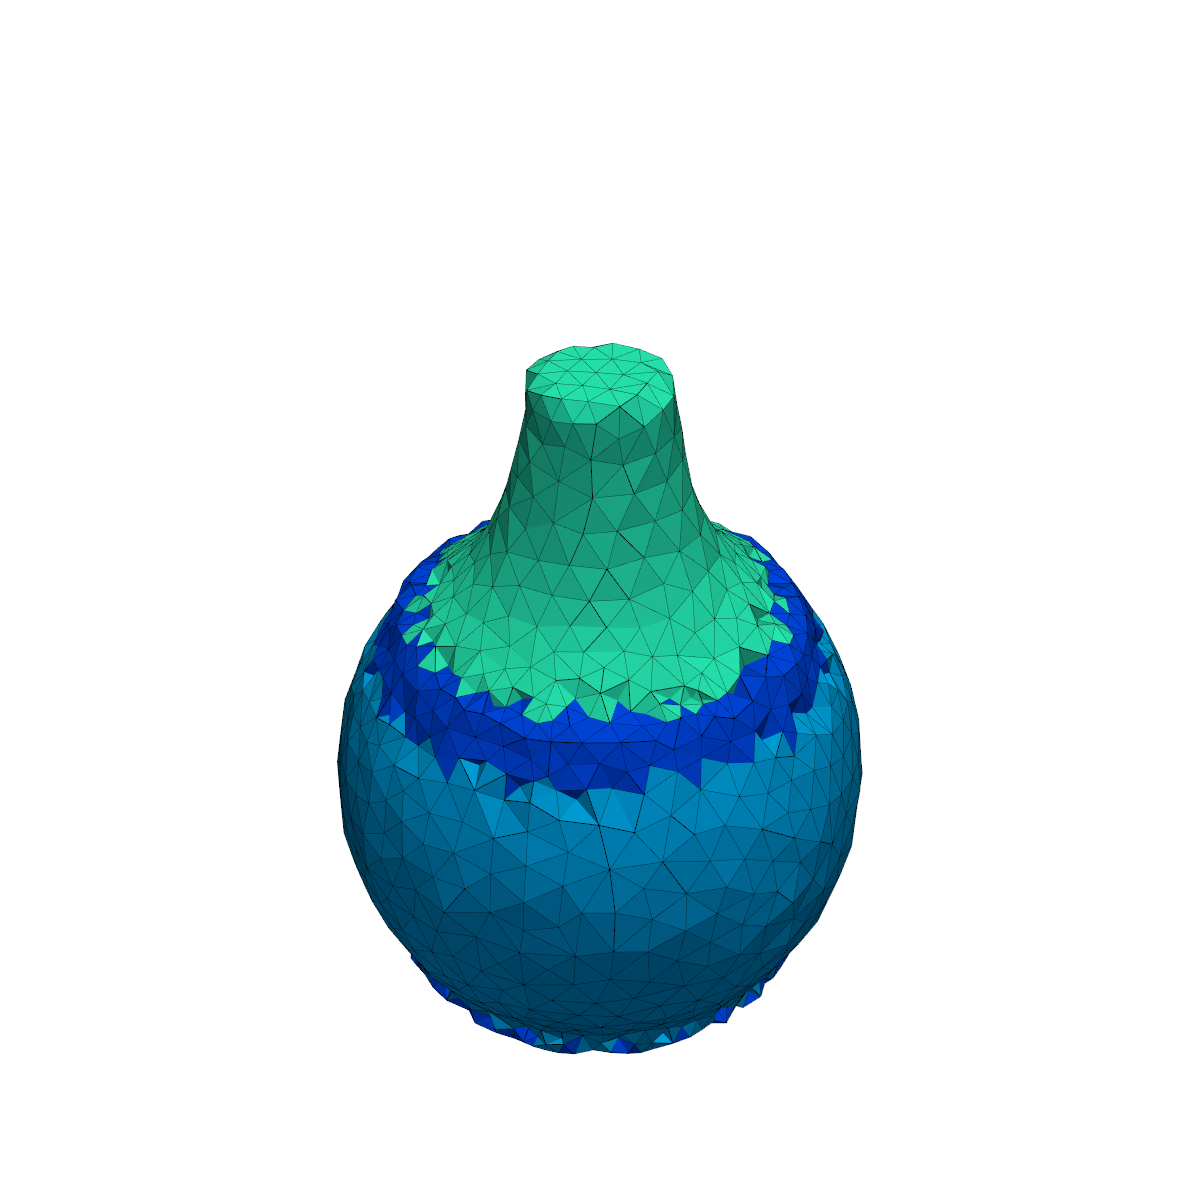

In [125]:
vol_mesh = project.core.fileio.load_meshio(ex.paths['volume_mesh'])

p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(vol_mesh, scalar='label', cmap='jet', clim=(0, 10), opacity=1.0, plotter=p, show_scalar_bar=False)
p = project.visual.pyvista.plot_mesh(vol_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

# Assign materials and properties

In [22]:
project.preprocessing.api.create_material_fields(
    mask_path=ex.paths['region_mask'],
    density_path=ex.paths['density_field'],
    elastic_path=ex.paths['elastic_field'],
    output_path=ex.paths['material_mask']
)

Loading ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/masks/regions.nii.gz
Assigning material properties to regions
Building material catalog
  density_key  density_val  density_freq elastic_key  elastic_val  \
0         0.0          0.0          0.00         0.0          0.0   
1       Dense        500.0          0.75        Hard       9000.0   
2       Dense        500.0          0.75      Medium       3000.0   
3       Dense        500.0          0.75        Soft       1000.0   
4      Porous        250.0          0.25        Hard       9000.0   
5      Porous        250.0          0.25      Medium       3000.0   
6      Porous        250.0          0.25        Soft       1000.0   

   elastic_freq  material_key  material_freq  poisson_ratio  
0          0.00    Background         0.0000            0.0  
1          0.25     DenseHard         0.1875            0.4  
2          0.50   DenseMedium         0.3750            0.4  
3          0.25     DenseSoft         0.18

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/fields/elasticity.nii.gz


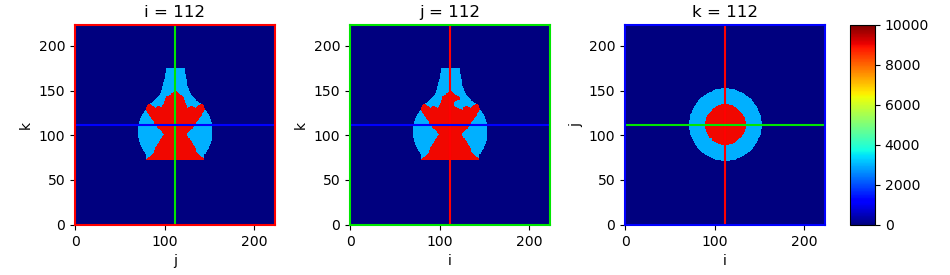

In [43]:
nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
elast = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(elast, cmap='jet', clim=(0, 1e4))

In [44]:
np.unique(elast, return_counts=True)

(array([   0., 3000., 9000.]), array([10928289,   188702,   122433]))

# Forward FEM simulation

In [41]:
%autoreload
project.preprocessing.api.simulate_displacement_field(
    mesh_path=ex.paths['volume_mesh'],
    density_path=ex.paths['density_field'],
    elastic_path=ex.paths['elastic_field'],
    nodes_path=ex.paths['node_values'],
    output_path=ex.paths['disp_field'],
    unit_m=float(ex.metadata['unit']),
    rasterize=False
)

Loading ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/fields/elasticity.nii.gz
Simulating displacement using material fields
Interpolating material fields onto mesh nodes
Simulating displacement using PDE solver
tensor(-19931.6699, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
E (3845, 1) float32 2068.305
mu (3845, 1) float32 738.6803
lam (3845, 1) float32 2954.721
rho (3845, 1) float32 399.50183
bc (3845, 3) float32 0.0
u (3845, 3) float32 -1.7279296
r (3845, 3) float32 0.0
Saving ../../data/ShapeNetSem/TEST/fabf4f7a56f75781c9c120e7b18610ad/meshes/node_values.xdmf


In [130]:
fem_mesh = project.core.fileio.load_meshio(ex.paths['node_values'])
fem_mesh.point_data['u'].mean()

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/node_values.xdmf


np.float32(-0.9591985)

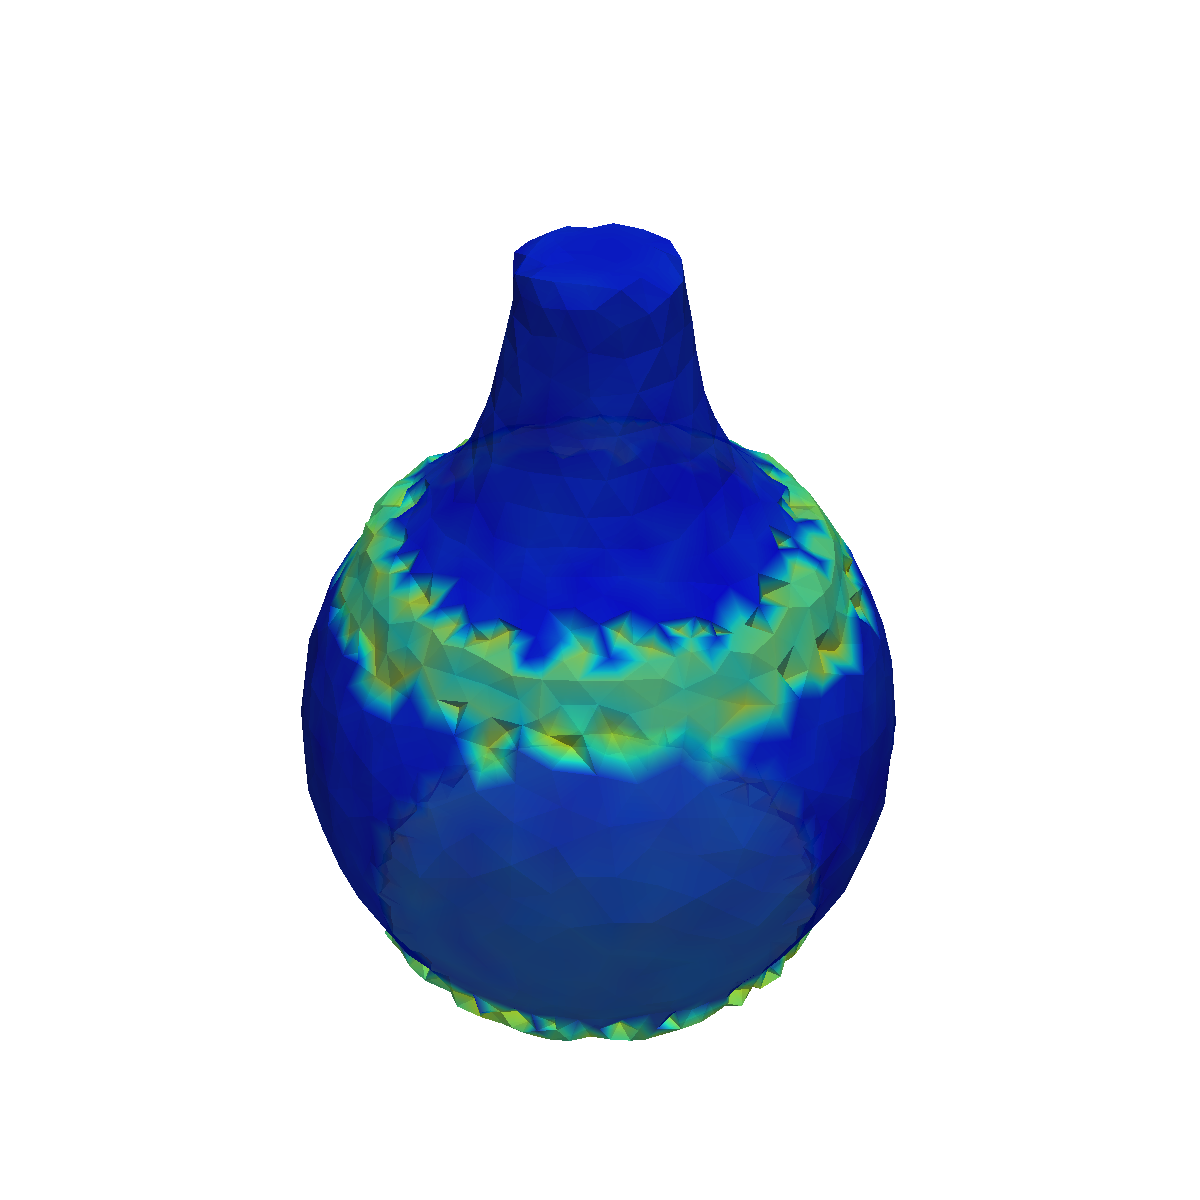

In [133]:
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(fem_mesh, scalar='E', cmap='jet', clim=(0, 1e4), opacity=0.8, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(fem_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
#p.camera = cam
p.show(jupyter_backend='static')

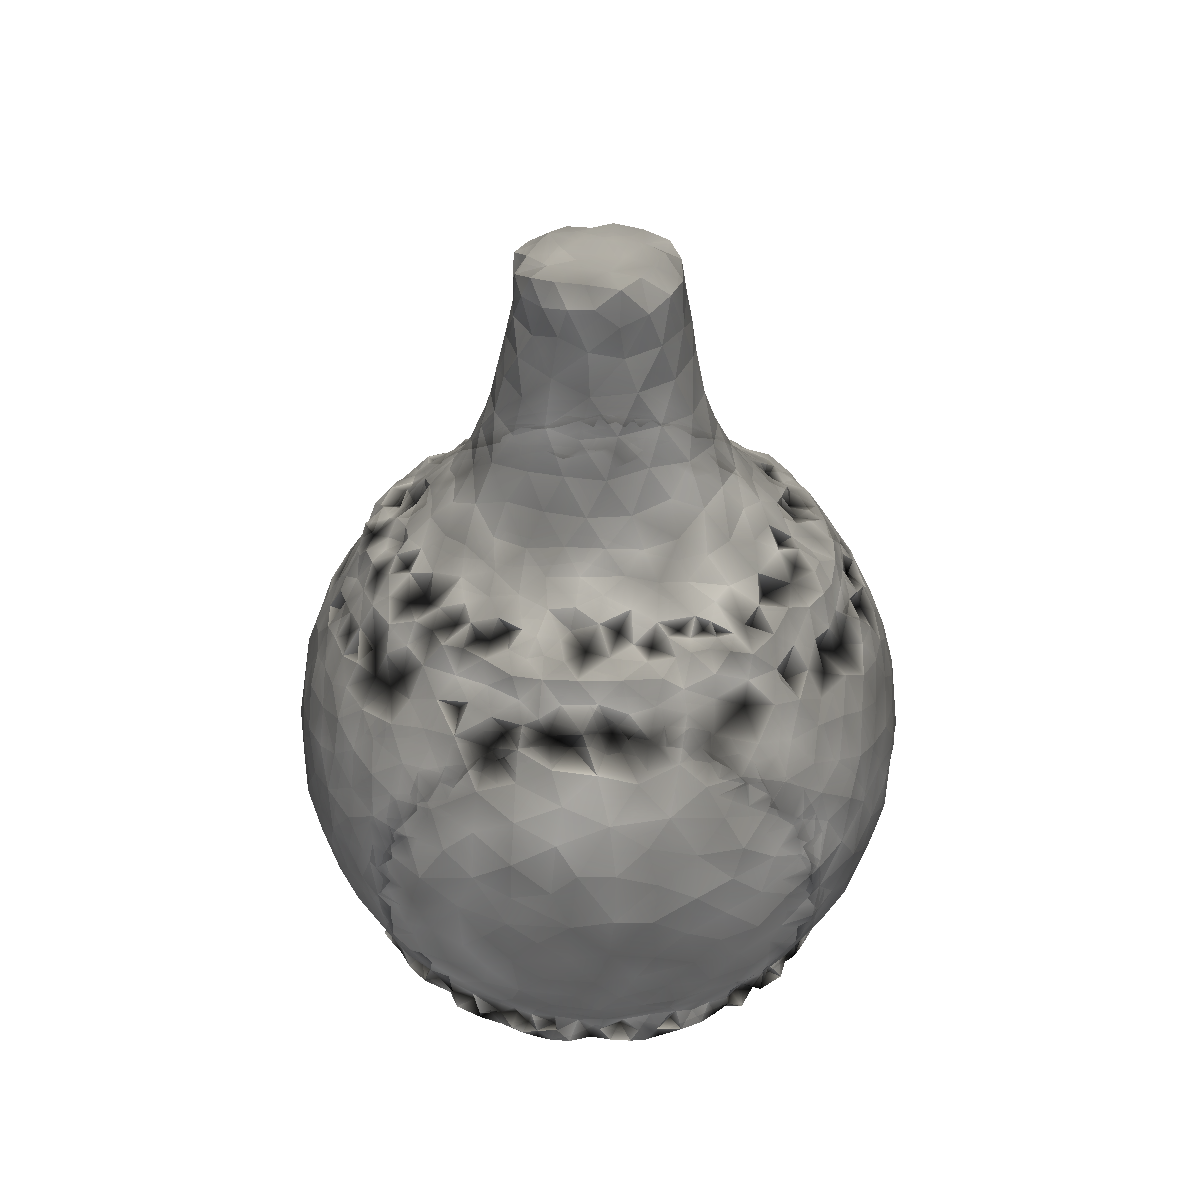

In [136]:
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(fem_mesh, scalar='rho', cmap='binary', opacity=0.8, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(fem_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
#p.camera = cam
p.show(jupyter_backend='static')

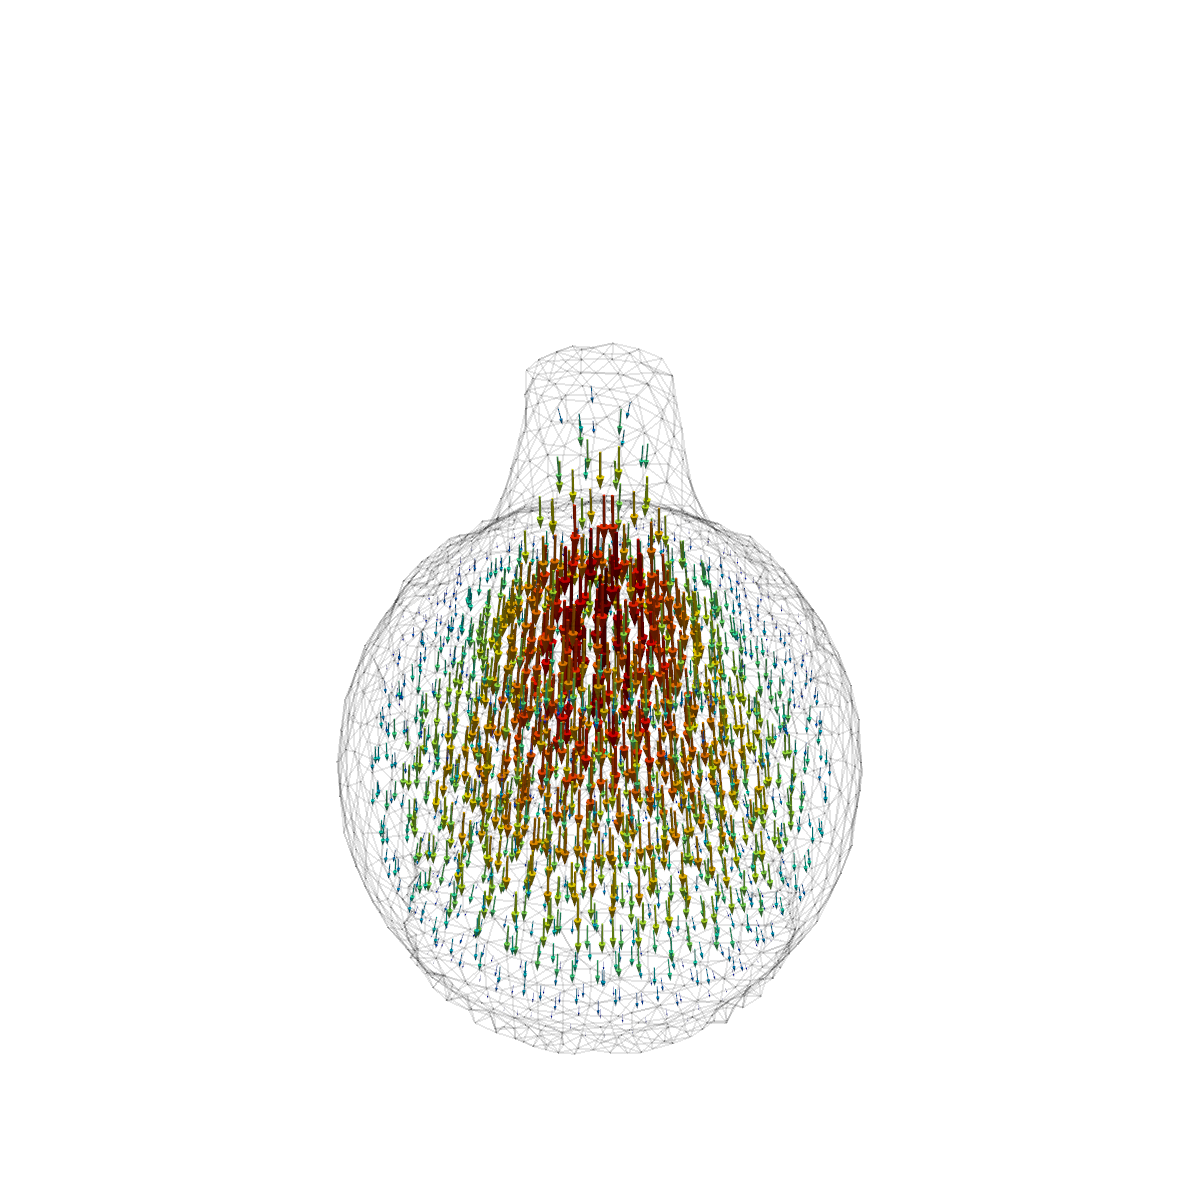

In [140]:
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(fem_mesh, style='wireframe', color='black', plotter=p, opacity=0.1, line_width=lw, show_scalar_bar=False)
p.add_mesh(project.visual.pyvista.pv.wrap(fem_mesh).glyph(scale='u', orient='u', factor=10), cmap='jet', show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

In [8]:
ex.metadata['unit']

0.0002838082877318012

# Texture annotations

In [60]:
import os
tex = pd.read_csv('2025-10-21_annotations.csv')
tex.path = tex.path.map(os.path.abspath)

# manual corrections/additional annotations
tex.loc[[1, 76, 42], 'annotation'] = 'marble'
tex.loc[88, 'annotation'] = 'brick'
tex.loc[80, 'annotation'] = 'stone'
tex.loc[ 8, 'annotation'] = 'fiberboard'
tex.loc[[84, 90], 'annotation'] = 'grass'
tex.loc[97, 'annotation'] = 'stone'
tex.loc[ 3, 'annotation'] = 'cardboard'
tex.loc[[27, 72, 54, 89, 74, 73], 'annotation'] = 'paper'
tex.loc[[74, 100], 'annotation'] = 'fabric'
tex.loc[[34], 'annotation'] = 'stone'
tex.loc[[98, 103], 'annotation'] = 'gravel'
tex.loc[[56], 'annotation'] = 'paint'
tex.loc[[101], 'annotation'] = 'paper'

tex.loc[:, 'is_texture'] = True
tex.loc[[32, 82, 13, 41, 113, 33, 87, 7, 28, 20, 56, 3, 77], 'is_texture'] = False

tex.loc[:, 'is_duplicate'] = False
tex.loc[[10, 12, 29, 40, 57, 60, 61, 71, 95, 80, 51, 22, 105, 59, 94, 68, 69, 109, 110, 4, 23, 24, 36, 43, 47, 62, 79, 18, 26, 76, 90, 106, 38], 'is_duplicate'] = True

tex.loc[:, 'poor_quality'] = False
tex.loc[[5, 45, 17, 48, 67, 92, 83, 81, 53, 2, 16, 39, 88, 49, 21], 'poor_quality'] = True

tex.loc[:, 'bad_shape'] = False
tex.loc[[73, 89, 75, 97, 85, 19, 107, 100, 111], 'bad_shape'] = True

tex.loc[:, 'inverted'] = False
tex.loc[[55], 'inverted'] = True
tex

idx                                               path annotation  \
0    18231  /ocean/projects/asc170022p/mtragoza/lung-proje...     carpet   
1    17033  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
2    18752  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
3    17435  /ocean/projects/asc170022p/mtragoza/lung-proje...  cardboard   
4     3048  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
..     ...                                                ...        ...   
109     42  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
110  12807  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
111   5066  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
113   1626  /ocean/projects/asc170022p/mtragoza/lung-proje...      metal   

     is_texture  is_duplicate  poor_quality  bad_shape  inverted  
0          True         False         False      False     False  
1          True         False         False      False     False  
2          True         False          True      False     False  
3         False         False         False      False     False  
4          True          True         False      False     False  
..          ...           ...           ...        ...       ...  
109        True          True         False      False     False  
110        True          True         False      False     False  
111        True         False         False       True     False  
112        True         False         False      False     False  
113       False         False         False      False     False  

[114 rows x 8 columns]

In [16]:
texture_type_to_material = {
    'paper':   'DenseSoft',
    'leather': 'DenseMedium',
    'stone':   'DenseHard',
    'fabric':  'PorousSoft',
    'wood':    'PorousMedium',
    'marble':  'PorousHard'
}
is_valid = tex.is_texture & ~(tex.is_duplicate | tex.poor_quality | tex.bad_shape)
tex.loc[is_valid, 'material'] = tex.annotation.map(texture_type_to_material)
tex.groupby('material').count()

idx  path  annotation  is_texture  is_duplicate  poor_quality  \
material                                                                      
DenseHard       3     3           3           3             3             3   
DenseMedium     4     4           4           4             4             4   
DenseSoft       4     4           4           4             4             4   
PorousHard      3     3           3           3             3             3   
PorousMedium    4     4           4           4             4             4   
PorousSoft      4     4           4           4             4             4   

              bad_shape  inverted  
material                           
DenseHard             3         3  
DenseMedium           4         4  
DenseSoft             4         4  
PorousHard            3         3  
PorousMedium          4         4  
PorousSoft            4         4

In [17]:
#tex.to_csv('texture_annotations_2025-10-25.csv', index=False)

In [18]:
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet'

6 4


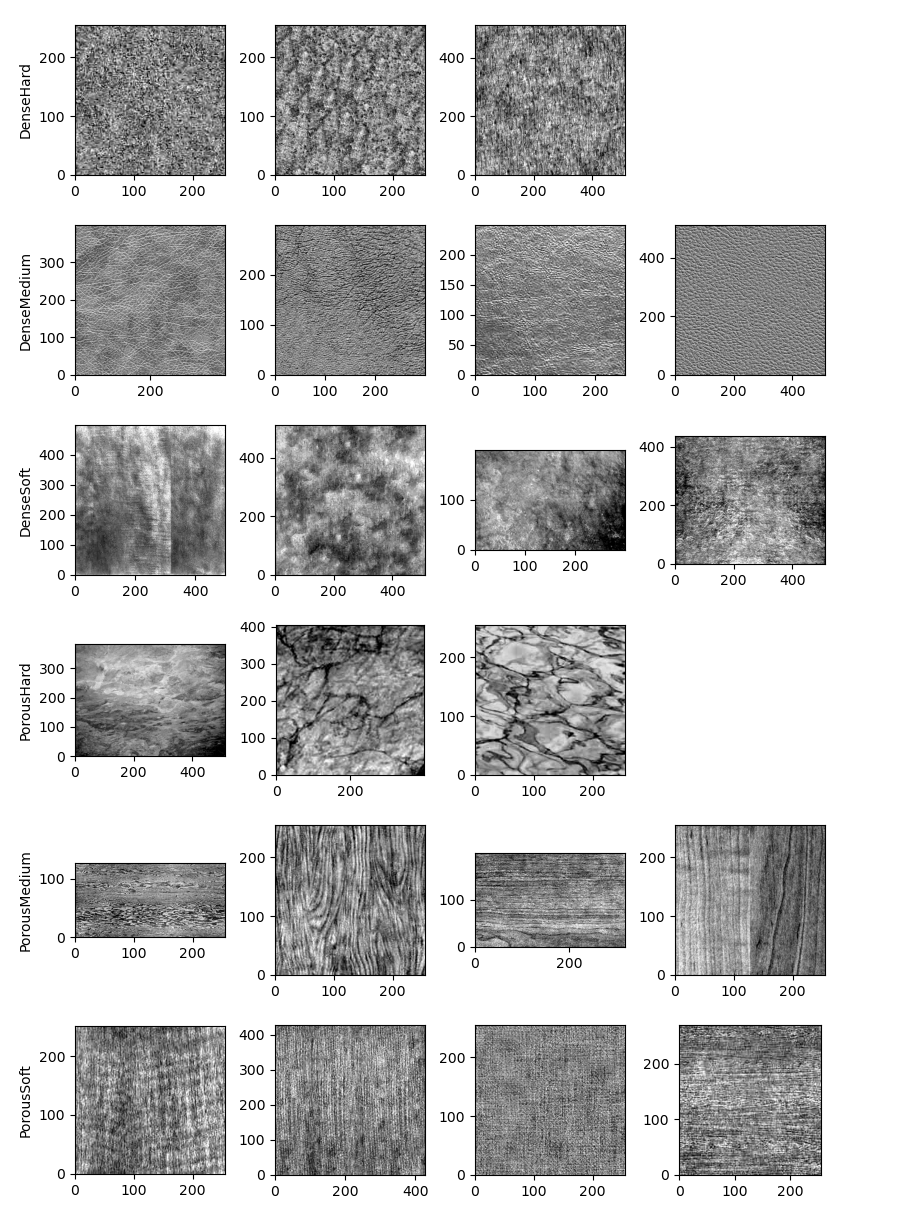

In [86]:
tex_cache = project.preprocessing.texturing.build_texture_cache(
    path='2025-10-25_annotations.csv',
    iqr_mult=4.0
)
_ = project.preprocessing.texturing.show_textures(tex_cache.dropna().set_index('material'))

In [153]:
import os
tex_cache['tid'] = tex_cache['path'].map(lambda p: os.path.splitext(os.path.basename(p))[0])
tex_cache['solid_path'] = tex_cache['tid'].map(lambda p: os.path.join(stn_root, f'{p}.nii'))
tex_cache['has_solid'] = tex_cache['solid_path'].map(os.path.isfile)
tex_cache

idx                                               path annotation  \
0    18231  /ocean/projects/asc170022p/mtragoza/lung-proje...     carpet   
1    17033  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
2    18752  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
3    17435  /ocean/projects/asc170022p/mtragoza/lung-proje...  cardboard   
4     3048  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
..     ...                                                ...        ...   
109     42  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
110  12807  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
111   5066  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
113   1626  /ocean/projects/asc170022p/mtragoza/lung-proje...      metal   

     is_texture  is_duplicate  poor_quality  bad_shape  inverted     material  \
0          True         False         False      False     False          NaN   
1          True         False         False      False     False   PorousHard   
2          True         False          True      False     False          NaN   
3         False         False         False      False     False          NaN   
4          True          True         False      False     False          NaN   
..          ...           ...           ...        ...       ...          ...   
109        True          True         False      False     False          NaN   
110        True          True         False      False     False          NaN   
111        True         False         False       True     False          NaN   
112        True         False         False      False     False  DenseMedium   
113       False         False         False      False     False          NaN   

                                                 image               tid  \
0    [[0.33454344, 0.6776649, 0.33454344, -0.214450...  e6808abd1cabdb24   
1    [[-0.40393445, -0.33110657, -0.26356593, -0.28...  7f0e6f6c35b92937   
2    [[-0.44608647, -0.44608647, -0.35414773, -0.07...  6db39e57639bf9d9   
3    [[1.0, 0.8230684, 0.68741035, 0.74088115, 0.77...  5313c2eeedd0125e   
4    [[0.046150718, -0.21117082, -0.28466192, -0.02...  796afcb7cc115983   
..                                                 ...               ...   
109  [[-0.22436179, -0.28468704, -0.4053375, -0.405...  d15eba3dff90a924   
110  [[-0.47208318, -0.28346837, -0.28346837, -0.28...  ffd0685cc9fdb37d   
111  [[0.3253993, 0.3253993, 0.31027263, 0.3403518,...  7243d927dcd5591e   
112  [[-0.3016089, -0.34987748, -0.56708616, -0.205...  17fababfd85461d1   
113  [[-0.3723731, -0.25, 0.035537235, 0.32107446, ...  1a304374facc41b3   

                                            solid_path  has_solid  
0    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
1    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
2    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
3    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
4    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
..                                                 ...        ...  
109  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
110  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
111  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
112  /ocean/projects/asc170022p/mtragoza/SolidTextu...       True  
113  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  

[114 rows x 13 columns]

In [154]:
tex_cache[tex_cache.has_solid]

idx                                               path annotation  \
6     4902  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
9    19893  /ocean/projects/asc170022p/mtragoza/lung-proje...      stone   
14   17986  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
15   20609  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
27   21243  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
30    5286  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
31   10918  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
34    7835  /ocean/projects/asc170022p/mtragoza/lung-proje...      stone   
42    3332  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
44   13040  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
46   16689  /ocean/projects/asc170022p/mtragoza/lung-proje...      stone   
50    6344  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
54    2146  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
55    7902  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
64   14537  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
72    9413  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
74   13590  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
96    5504  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
101  10655  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
108     35  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   

     is_texture  is_duplicate  poor_quality  bad_shape  inverted  \
6          True         False         False      False     False   
9          True         False         False      False     False   
14         True         False         False      False     False   
15         True         False         False      False     False   
27         True         False         False      False     False   
30         True         False         False      False     False   
31         True         False         False      False     False   
34         True         False         False      False     False   
42         True         False         False      False     False   
44         True         False         False      False     False   
46         True         False         False      False     False   
50         True         False         False      False     False   
54         True         False         False      False     False   
55         True         False         False      False      True   
64         True         False         False      False     False   
72         True         False         False      False     False   
74         True         False         False      False     False   
96         True         False         False      False     False   
101        True         False         False      False     False   
108        True         False         False      False     False   
112        True         False         False      False     False   

         material                                              image  \
6     DenseMedium  [[0.2775573, 0.31255072, -0.08738207, -0.12237...   
9       DenseHard  [[0.5625, 0.03125, -0.3125, -0.15625, 0.1875, ...   
14   PorousMedium  [[-0.19273575, -0.033357855, 0.08055496, 0.027...   
15     PorousSoft  [[0.57493937, 0.81178844, 0.7525762, 0.2196657...   
27      DenseSoft  [[0.8036085, 0.6369415, 0.5536082, 0.5536082, ...   
30   PorousMedium  [[-0.36722708, -0.41444668, -0.46166632, -0.36...   
31     PorousSoft  [[0.7858724, 0.399532, 0.013191582, -0.1799786...   
34      DenseHard  [[0.012953353, -0.25393695, -0.25222063, -0.15...   
42     PorousHard  [[-1.0, -1.0, -1.0, -1.0, -0.870204, -0.741029...   
44   PorousMedium  [[-0.68449104, -0.4751938, -0.31822088, -0.370...   
46      DenseHard  [[0.7490162, 0.7490162, 0.

In [289]:
sol = tex_cache[tex_cache.has_solid].reset_index()

sol.loc[0, 'solid_valid'] = True
sol.loc[0, 'solid_annotation'] = 'leather'

sol.loc[1, 'solid_valid'] = False
sol.loc[1, 'solid_annotation'] = 'stone, some LFO'

sol.loc[2, 'solid_valid'] = True
sol.loc[2, 'solid_annotation'] = 'wood, anisotropic'

sol.loc[3, 'solid_valid'] = True
sol.loc[3, 'solid_annotation'] = 'fine fabric'

sol.loc[4, 'solid_valid'] = False
sol.loc[4, 'solid_annotation'] = 'paper - holes'

sol.loc[5, 'solid_valid'] = True
sol.loc[5, 'solid_annotation'] = 'wood, very aniso'
sol.loc[5, 'solid_selected'] = True

sol.loc[6, 'solid_valid'] = True
sol.loc[6, 'solid_annotation'] = 'fabric, gridlike'

sol.loc[7, 'solid_valid'] = True
sol.loc[7, 'solid_annotation'] = 'stone'
sol.loc[7, 'solid_selected'] = True

sol.loc[8, 'solid_valid'] = True
sol.loc[8, 'solid_annotation'] = 'marble, good!'
sol.loc[8, 'solid_selected'] = True

sol.loc[9, 'solid_valid'] = True
sol.loc[9, 'solid_annotation'] = 'wood, aniso'

sol.loc[10, 'solid_valid'] = False
sol.loc[10, 'solid_annotation'] = 'stone, stripey holes'

sol.loc[11, 'solid_valid'] = False
sol.loc[11, 'solid_annotation'] = 'fabric, large blobs'

sol.loc[12, 'solid_valid'] = True
sol.loc[12, 'solid_annotation'] = 'paper, pretty good'

sol.loc[13, 'solid_valid'] = True
sol.loc[13, 'solid_annotation'] = 'marble - interesting'

sol.loc[14, 'solid_valid'] = True
sol.loc[14, 'solid_annotation'] = 'leather, some spots'

sol.loc[15, 'solid_valid'] = True
sol.loc[15, 'solid_annotation'] = 'paper, good'
sol.loc[15, 'solid_selected'] = True

sol.loc[16, 'solid_valid'] = True
sol.loc[16, 'solid_annotation'] = 'fabric, good'
sol.loc[16, 'solid_selected'] = True

sol.loc[17, 'solid_valid'] = True
sol.loc[17, 'solid_annotation'] = 'leather, good'

sol.loc[18, 'solid_valid'] = True
sol.loc[18, 'solid_annotation'] = 'paper, decent'

sol.loc[19, 'solid_valid'] = True
sol.loc[19, 'solid_annotation'] = 'wood, ok'

sol.loc[20, 'solid_valid'] = True
sol.loc[20, 'solid_annotation'] = 'leather, very good'
sol.loc[20, 'solid_selected'] = True

sol[sol.solid_selected.notna()]

index    idx                                               path  \
5      30   5286  /ocean/projects/asc170022p/mtragoza/lung-proje...   
7      34   7835  /ocean/projects/asc170022p/mtragoza/lung-proje...   
8      42   3332  /ocean/projects/asc170022p/mtragoza/lung-proje...   
15     72   9413  /ocean/projects/asc170022p/mtragoza/lung-proje...   
16     74  13590  /ocean/projects/asc170022p/mtragoza/lung-proje...   
20    112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...   

   annotation  is_texture  is_duplicate  poor_quality  bad_shape  inverted  \
5        wood        True         False         False      False     False   
7       stone        True         False         False      False     False   
8      marble        True         False         False      False     False   
15      paper        True         False         False      False     False   
16     fabric        True         False         False      False     False   
20    leather        True         False         False      False     False   

        material                                              image  \
5   PorousMedium  [[-0.36722708, -0.41444668, -0.46166632, -0.36...   
7      DenseHard  [[0.012953353, -0.25393695, -0.25222063, -0.15...   
8     PorousHard  [[-1.0, -1.0, -1.0, -1.0, -0.870204, -0.741029...   
15     DenseSoft  [[-0.23199572, -0.21180023, -0.11082268, -0.07...   
16    PorousSoft  [[-0.34242475, -0.58153695, -0.5018329, -0.103...   
20   DenseMedium  [[-0.3016089, -0.34987748, -0.56708616, -0.205...   

                 tid                                         solid_path  \
5   2001a5b9a15a670c  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
7   a6c66d0eeaca8c03  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
8   b25c0f2ee0edc563  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
15  80703cf49d2a14c5  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
16  e99e6b2fa82e040a  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
20  17fababfd85461d1  /ocean/projects/asc170022p/mtragoza/SolidTextu...   

    has_solid solid_valid    solid_annotation solid_selected  
5        True        True    wood, very aniso           True  
7        True        True               stone           True  
8        True        True       marble, good!           True  
15       True        True         paper, good           True  
16       True        True        fabric, good           True  
20       True        True  leather, very good           True

index                                                             112
idx                                                              5531
path                /ocean/projects/asc170022p/mtragoza/lung-proje...
annotation                                                    leather
is_texture                                                       True
is_duplicate                                                    False
poor_quality                                                    False
bad_shape                                                       False
inverted                                                        False
material                                                  DenseMedium
image               [[-0.3016089, -0.34987748, -0.56708616, -0.205...
tid                                                  17fababfd85461d1
solid_path          /ocean/projects/asc170022p/mtragoza/SolidTextu...
has_solid                                                        True
solid_valid         

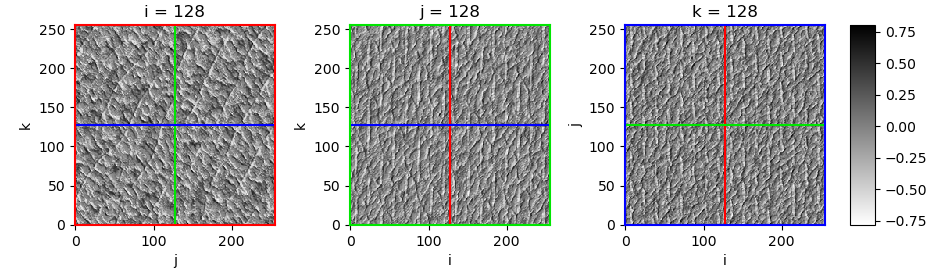

In [292]:
%%time
import nibabel as nib

def preprocess3d(a, iqr_mult=6.0):
    import skimage
    x = skimage.util.img_as_float(a)
    x = skimage.color.rgb2gray(x)
    x = project.preprocessing.texturing._normalize_iqr(x, iqr_mult=iqr_mult)
    x = np.clip(x, -1., 1.).astype(np.float32)
    return x

row = sol.loc[20]
print(row)

t = preprocess3d(nib.load(row.solid_path).get_fdata()[:256,:256,:256])
_ = project.visual.matplotlib.show_image_slices(t, cmap='binary')

In [294]:
sol.to_csv('texture_annotations_2025-11-05.csv', index=False)

# Image generation

$$
\begin{align}
    \tilde{I}(x) &= I(x) \times \left(1 + \sigma_m \eta_m(x) \right) + \sigma_a \eta_a(x)  \\
    I(x) &= b_k + r_k \, \tilde{T}_k(x) \quad \text{for} \quad M(x) = k \\
    \tilde{T}(x) &= T(x) + \eta_t(x) \\
\end{align}
$$
Where:
$$
\begin{align}
    b_k &= b_0 + b_1 \, d_m + b_2 \, e_m \\
    r_k &= r_0 + r_1 \, d_m + r_2 \, e_m
\end{align}
$$
And:
$$
\begin{align}
    d_m = \max \left( \frac{\rho_m}{\rho_0}, 0 \right) \qquad e_m = \max \left( \frac{E_m}{E_0}, \epsilon \right)^{-1}
\end{align}
$$

In [4]:
%autoreload
imp_kws = dict(d_ref=500, e_ref=1000, e_pow=-1, b_d=0.5, r_de=0.5)
mat_df = project.preprocessing.materials.build_material_catalog()
mat_df = project.preprocessing.materials.assign_image_parameters(mat_df, **imp_kws)
mat_df

AttributeError: module 'project.preprocessing' has no attribute 'materials'

In [5]:
subjects = pd.read_csv('2025-11-02_selected.csv').subject.tolist()
examples = ds.examples(subjects, variant='2025-11-02')

In [31]:
ex = next(examples)

In [32]:
%autoreload
project.preprocessing.api.generate_volumetric_image(
    mask_path=ex.paths['material_mask'],
    output_path=ex.paths['input_image'],
    annot_path='2025-11-05_annotations.csv',
    imp_kws=dict(d_ref=500, e_ref=1000, e_pow=-1, b_d=0.5, r_de=0.5),
    gen_kws=dict(
        iqr_mult=4.0, use_solid=True, seed=0,
        tex_noise_len=2.0,
        tex_noise_std=0.1,
        mul_noise_len=128.,
        mul_noise_std=0.25,
        add_noise_len=0.5,
        add_noise_std=0.025,
        psf_sigma=0.5,
        mat_sigma=2.0,
    )
)

Loading ../../data/ShapeNetSem/2025-11-02/101354f9d8dede686f7b08d9de913afe/masks/material.nii.gz
Building material catalog
   material_key  density_feat    elastic_feat    image_bias  image_range
0    Background      0.000001  1000000.000000  5.000000e-07     0.500000
1     DenseHard      1.000000        0.111111  5.000000e-01     0.055556
2   DenseMedium      1.000000        0.333333  5.000000e-01     0.166667
3     DenseSoft      1.000000        1.000000  5.000000e-01     0.500000
4    PorousHard      0.500000        0.111111  2.500000e-01     0.027778
5  PorousMedium      0.500000        0.333333  2.500000e-01     0.083333
6    PorousSoft      0.500000        1.000000  2.500000e-01     0.250000
Loading texture annotations
Generating volumetric image
Background | bias = 0.0000 range = 0.0000
DenseHard | bias = 0.5000 range = 0.0556
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/a6c66d0eeaca8c03.nii
DenseMedium | bias = 0.5000 range = 0.1667
DenseSoft | bias = 0.

Loading ../../data/ShapeNetSem/2025-11-02/101354f9d8dede686f7b08d9de913afe/images/generated.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz
(-0.18666255474090576, 1.6143027544021606)


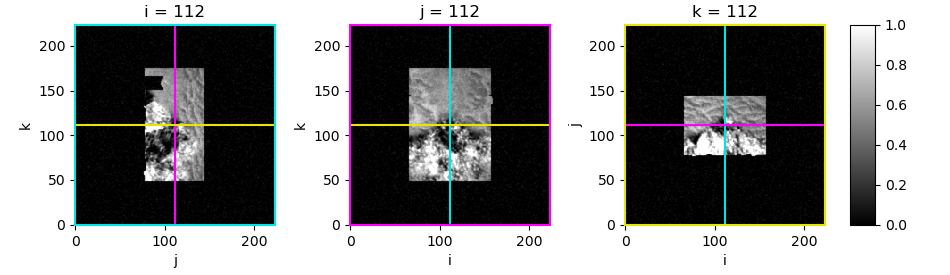

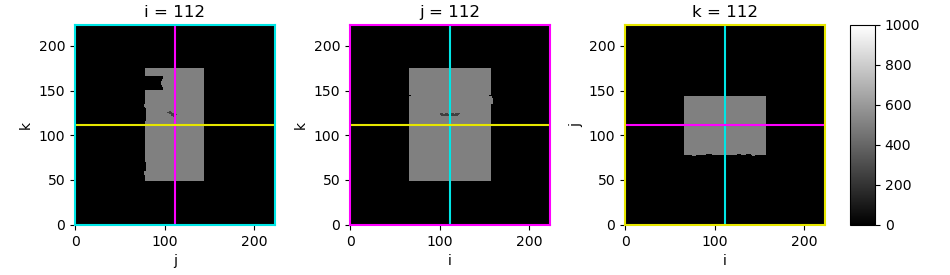

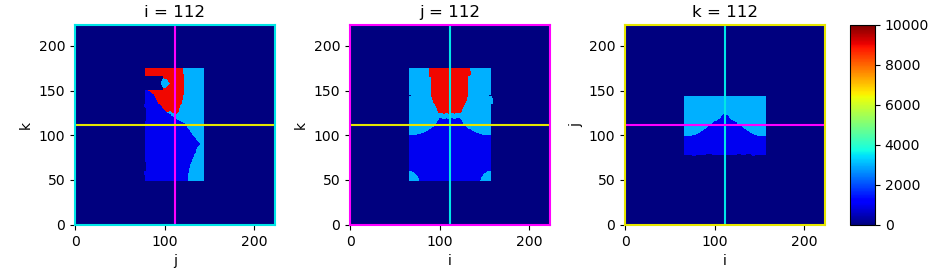

In [33]:
%matplotlib widget
import project.visual.matplotlib

image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
density = project.core.fileio.load_nibabel(ex.paths['density_field']).get_fdata()
elastic = project.core.fileio.load_nibabel(ex.paths['elastic_field']).get_fdata()

clim = (float(image.min()), float(image.max()))
print(clim)

_ = project.visual.matplotlib.show_image_slices(image, cmap='gray', clim=(0, 1), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(density, cmap='gray', clim=(0, 1000), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(elastic, cmap='jet',  clim=(0, 10000), colors='cmy')